In [1]:
%matplotlib widget
import warnings
warnings.filterwarnings("ignore") 

In [15]:
import time
import numpy as np
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qm import QuantumMachinesManager
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.loops import from_array
from progress import addjob, ProgressPlot, rescale, update, updateIQ
import threading
import config_qubit as config

In [3]:
# Connect to the cluster (run only once)
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name)

2025-09-28 14:12:53,506 - qm - INFO     - Performing health check
2025-09-28 14:12:53,511 - qm - INFO     - Health check passed


# Connect to the running QM

In [4]:
# Get the## QM reference (rerun every time the config is changed)
qm_list =  qmm.list_open_qms()
qm = qmm.get_qm(qm_list[0])
print(f"Connected to {qm.id}")

Connected to qm-1695624634080


## Recap of the config

### Qubit
qubit_LO = 3819.2 * u.MHz  
qubit_IF = 50 * u.MHz
#### Long square "saturation" pulse (`saturation`)
saturation_len = 20 * u.us  
saturation_amp = 0.1
#### Square pulse (`pi`, `pi_half`)
square_pi_len = 120 * u.ns  
square_pi_amp = 0.125  
square_pi_half_amp = square_pi_amp/2
#### Gaussian pulses (`x180`, `y180`, `x90`, `y90`)
rot_180_len = 248 * u.ns  
rot_180_sigma = rot_180_len/5  
rot_180_amp = 0.125  
rot_90_len = rot_180_len  
rot_90_sigma = rot_180_sigma  
rot_90_amp = rot_180_amp/2  

### Readout Resonator
resonator_LO = 5929.3 * u.MHz  
resonator_IF = 60 * u.MHz  
#### Readout pulse (`readout`)
readout_len = 2800
readout_delay = 800 
readout_amp = 0.125
time_of_flight = 256 * u.ns   

# Resonator Spectroscopy

In [16]:
# Parameters Definition
n_avg = 200  # Number of averages
# IF frequency sweep
center = 60 * u.MHz
span = 40 * u.MHz
df = 100 * u.kHz
dfs = np.arange(-span/2, +span/2, df) + center
thermalization_time = 80 # Waiting time between two iterations in µs

###################
# The QUA program #
###################
with program() as resonator_spec:
    n = declare(int)  # QUA variable for the averaging loop
    f = declare(int)  # QUA variable for the readout frequency
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature
    n_st = declare_stream()  # Stream for the averaging iteration 'n'

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(f, dfs)):  # QUA for_ loop for sweeping the frequency
            # Update the frequency of the digital oscillator linked to the resonator element
            update_frequency("resonator", f)
            # Measure the resonator (send a readout pulse and demodulate the signals to get the 'I' & 'Q' quadratures)
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the resonator to deplete
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)
        # Save the averaging iteration to get the progress bar
        save(n, n_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(dfs)).average().save("I")
        Q_st.buffer(len(dfs)).average().save("Q")
        n_st.save("iteration")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(resonator_spec, qm)

2025-09-28 14:15:37,481 - qm - INFO     - Sending program to QOP for compilation

Job is running


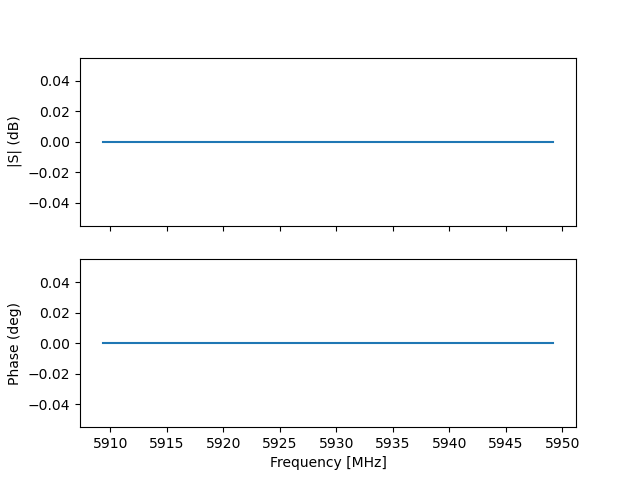

In [17]:
# Real time monitoring and plotting
results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")

# Create plot
pp = ProgressPlot()
ax = pp.fig.subplots(2,1,sharex=True)
l_modulous, = ax[0].plot(dfs/u.MHz + config.resonator_LO/u.MHz, np.zeros_like(dfs))
l_phase, = ax[1].plot(dfs/u.MHz + config.resonator_LO/u.MHz, np.zeros_like(dfs))
ax[0].set_ylabel("|S| (dB)")
ax[1].set_ylabel("Phase (deg)")
ax[1].set_xlabel("Frequency [MHz]")
    
pp.show()
thread = threading.Thread(target=update, args=(pp, n_avg, job, dfs, results, ax, l_modulous, l_phase))
thread.start()

# Qubit Spectroscopy

In [22]:
# Parameters Definition
n_avg = 500  # The number of averages
# Adjust the pulse duration and amplitude to drive the qubit into a mixed state
saturation_len = 20000 * u.ns  
saturation_amp = 0.1  # pre-factor to the value defined in the config - restricted to [-2; 2)
# Qubit detuning sweep
center = 50 * u.MHz
span = 8 * u.MHz
df = 50 * u.kHz
dfs = center + np.arange(-span/2, span/2, df)
thermalization_time = 80

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    df = declare(int)  # QUA variable for the qubit frequency
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature
    n_st = declare_stream()  # Stream for the averaging iteration 'n'

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(df, dfs)):
            # Update the frequency of the digital oscillator linked to the qubit element
            update_frequency("qubit", df)
            # Play the saturation pulse to put the qubit in a mixed state - Can adjust the amplitude on the fly [-2; 2)
            play("saturation" * amp(saturation_amp), "qubit", duration=saturation_len * u.ns)
            # Align the two elements to measure after playing the qubit pulse.
            # One can also measure the resonator while driving the qubit by commenting the 'align'
            align("qubit", "resonator")
            # Measure the state of the resonator
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)
        # Save the averaging iteration to get the progress bar
        save(n, n_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(dfs)).average().save("I")
        Q_st.buffer(len(dfs)).average().save("Q")
        n_st.save("iteration")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

2025-09-28 14:16:38,291 - qm - INFO     - Sending program to QOP for compilation

Job is running


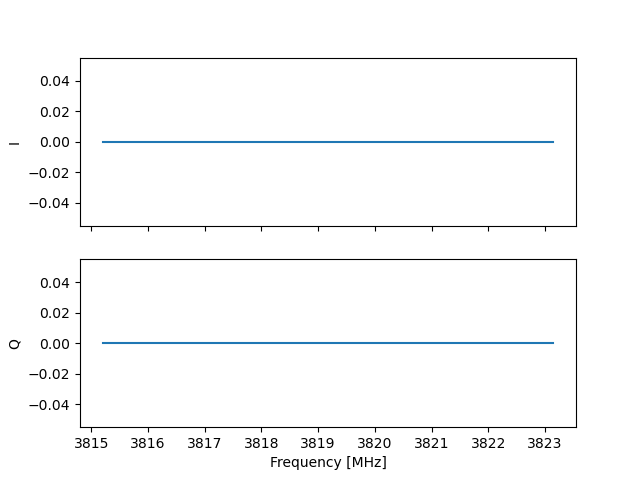

In [23]:
# Real time monitoring and plotting
results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")

# Create plot
pp = ProgressPlot()
ax = pp.fig.subplots(2,1,sharex=True)
l_I, = ax[0].plot(dfs/u.MHz + config.qubit_LO/u.MHz, np.zeros_like(dfs))
l_Q, = ax[1].plot(dfs/u.MHz + config.qubit_LO/u.MHz, np.zeros_like(dfs))
ax[0].set_ylabel("I")
ax[1].set_ylabel("Q")
ax[1].set_xlabel("Frequency [MHz]")
    
pp.show()
thread = threading.Thread(target=updateIQ, args=(pp, n_avg, job, results, ax, l_I, l_Q))
thread.start()

# Rabi Oscillations

In [24]:
# Parameters Definition
n_avg = 500  # The number of averages
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
t_min = 4 // 4
t_max = 1000 // 4
dt = 8 // 4
durations = np.arange(t_min, t_max, dt)
thermalization_time = 80 #in µs

###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    I_st = declare_stream()  # Stream for the 'I' quadrature
    Q_st = declare_stream()  # Stream for the 'Q' quadrature
    n_st = declare_stream()  # Stream for the averaging iteration 'n'

    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
            # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
            play("pi", "qubit", duration=t)
            # Align the two elements to measure after playing the qubit pulse.
            align("qubit", "resonator")
            # Measure the state of the resonator
            # The integration weights have changed to maximize the SNR after having calibrated the IQ blobs.
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
            )
            # Wait for the qubit to decay to the ground state
            wait(thermalization_time * u.us, "resonator")
            # Save the 'I' & 'Q' quadratures to their respective streams
            save(I, I_st)
            save(Q, Q_st)
        # Save the averaging iteration to get the progress bar
        save(n, n_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        I_st.buffer(len(durations)).average().save("I")
        Q_st.buffer(len(durations)).average().save("Q")
        n_st.save("iteration")

# Send the QUA program to the OPX, which compiles and executes it
job = addjob(qmprog, qm)

2025-09-28 14:16:52,113 - qm - INFO     - Sending program to QOP for compilation

Job is running


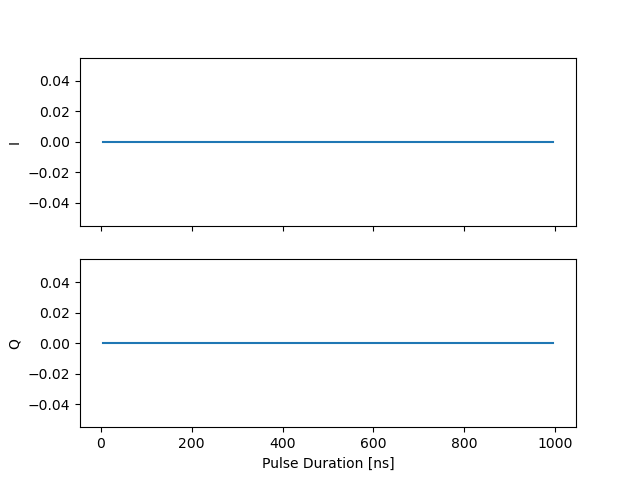

In [26]:
# Real time monitoring and plotting
results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")

# Create plot
pp = ProgressPlot()
ax = pp.fig.subplots(2,1,sharex=True)
l_I, = ax[0].plot(4*durations, np.zeros_like(durations))
l_Q, = ax[1].plot(4*durations, np.zeros_like(durations))
ax[0].set_ylabel("I")
ax[1].set_ylabel("Q")
ax[1].set_xlabel("Pulse Duration [ns]")

pp.show()
thread = threading.Thread(target=updateIQ, args=(pp, n_avg, job, results, ax, l_I, l_Q))
thread.start()